# Instacart Consumer Behavior Analytics & RFM Analysis

This notebook performs:
1. **ETL (Extract, Transform, Load)** - Data loading and basic cleaning
2. **Exploratory Data Analysis (EDA)** - Understanding the dataset structure and patterns
3. **Consumer Behavior Analysis** - Order patterns, temporal analysis, product preferences
4. **RFM Segmentation** - Customer segmentation based on Recency, Frequency, and Monetary proxy
5. **Cohort Analysis** - Understanding customer retention patterns

## Project Structure
- **Input**: `data/raw/` - Original Instacart dataset files
- **Output**: `data/processed/` - Cleaned and enriched datasets for downstream analysis
- **Features**: `data/features/` - Feature engineering outputs

In [1]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import os
from datetime import datetime, timedelta

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. ETL - Data Loading and Initial Exploration

Let's load all the Instacart dataset files and understand their structure.

In [2]:
# Define data paths
DATA_RAW_PATH = "../data/raw/"
DATA_PROCESSED_PATH = "../data/processed/"

# Load all dataset files
print("Loading Instacart dataset...")

# Load core datasets
orders = pd.read_csv(DATA_RAW_PATH + "orders.csv")
products = pd.read_csv(DATA_RAW_PATH + "products.csv")
aisles = pd.read_csv(DATA_RAW_PATH + "aisles.csv")
departments = pd.read_csv(DATA_RAW_PATH + "departments.csv")
order_products_train = pd.read_csv(DATA_RAW_PATH + "order_products__train.csv")
order_products_prior = pd.read_csv(DATA_RAW_PATH + "order_products__prior.csv")

print(f"✓ Orders: {orders.shape}")
print(f"✓ Products: {products.shape}")
print(f"✓ Aisles: {aisles.shape}")
print(f"✓ Departments: {departments.shape}")
print(f"✓ Order Products (Train): {order_products_train.shape}")
print(f"✓ Order Products (Prior): {order_products_prior.shape}")

print("\nDataset loaded successfully!")

Loading Instacart dataset...
✓ Orders: (3421083, 7)
✓ Products: (49688, 4)
✓ Aisles: (134, 2)
✓ Departments: (21, 2)
✓ Order Products (Train): (1384617, 4)
✓ Order Products (Prior): (32434489, 4)

Dataset loaded successfully!


In [3]:
# Explore dataset structures
print("=== ORDERS DATASET ===")
print(f"Shape: {orders.shape}")
print(f"Columns: {list(orders.columns)}")
print("\nSample data:")
display(orders.head())
print(f"\nData types:\n{orders.dtypes}")
print(f"\nMissing values:\n{orders.isnull().sum()}")

=== ORDERS DATASET ===
Shape: (3421083, 7)
Columns: ['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']

Sample data:


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0



Data types:
order_id                    int64
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
dtype: object

Missing values:
order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64


In [4]:
# Explore products dataset
print("=== PRODUCTS DATASET ===")
print(f"Shape: {products.shape}")
display(products.head())

# Check for product hierarchy
print("\n=== PRODUCT HIERARCHY ===")
print(f"Departments: {departments.shape[0]}")
print(f"Aisles: {aisles.shape[0]}")
print(f"Products: {products.shape[0]}")

# Sample from each
print("\nDepartments sample:")
display(departments.head())
print("\nAisles sample:")
display(aisles.head(10))

=== PRODUCTS DATASET ===
Shape: (49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13



=== PRODUCT HIERARCHY ===
Departments: 21
Aisles: 134
Products: 49688

Departments sample:


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol



Aisles sample:


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
5,6,other
6,7,packaged meat
7,8,bakery desserts
8,9,pasta sauce
9,10,kitchen supplies


## 2. Data Processing & Enrichment

Now let's combine the datasets and create enriched versions for analysis.

In [5]:
# Combine order products data
print("Combining order products datasets...")
order_products = pd.concat([order_products_prior, order_products_train], ignore_index=True)
print(f"Combined order_products shape: {order_products.shape}")

# Create enriched products dataset with hierarchy
products_enriched = products.merge(aisles, on='aisle_id', how='left') \
                           .merge(departments, on='department_id', how='left')

print(f"Products enriched shape: {products_enriched.shape}")
print("\nSample enriched products:")
display(products_enriched.head())

Combining order products datasets...
Combined order_products shape: (33819106, 4)
Products enriched shape: (49688, 6)

Sample enriched products:


,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


In [6]:
# Basic dataset statistics
print("=== DATASET OVERVIEW ===")
print(f"Total unique users: {orders['user_id'].nunique():,}")
print(f"Total orders: {orders.shape[0]:,}")
print(f"Total order items: {order_products.shape[0]:,}")
print(f"Total unique products: {products.shape[0]:,}")

# Evaluation set distribution
print(f"\n=== EVALUATION SET DISTRIBUTION ===")
eval_set_dist = orders['eval_set'].value_counts()
display(eval_set_dist)

# Order metrics
avg_order_size = order_products.groupby('order_id').size().mean()
print(f"\n=== ORDER METRICS ===")
print(f"Average order size: {avg_order_size:.2f} items")
print(f"Average orders per user: {orders.groupby('user_id').size().mean():.2f}")
print(f"Max order number per user: {orders['order_number'].max()}")

=== DATASET OVERVIEW ===
Total unique users: 206,209
Total orders: 3,421,083
Total order items: 33,819,106
Total unique products: 49,688

=== EVALUATION SET DISTRIBUTION ===


eval_set
prior    3214874
train     131209
test       75000
Name: count, dtype: int64


=== ORDER METRICS ===
Average order size: 10.11 items
Average orders per user: 16.59
Max order number per user: 100


## 3. Exploratory Data Analysis (EDA)

### 3.1 Temporal Patterns - Order Time Analysis

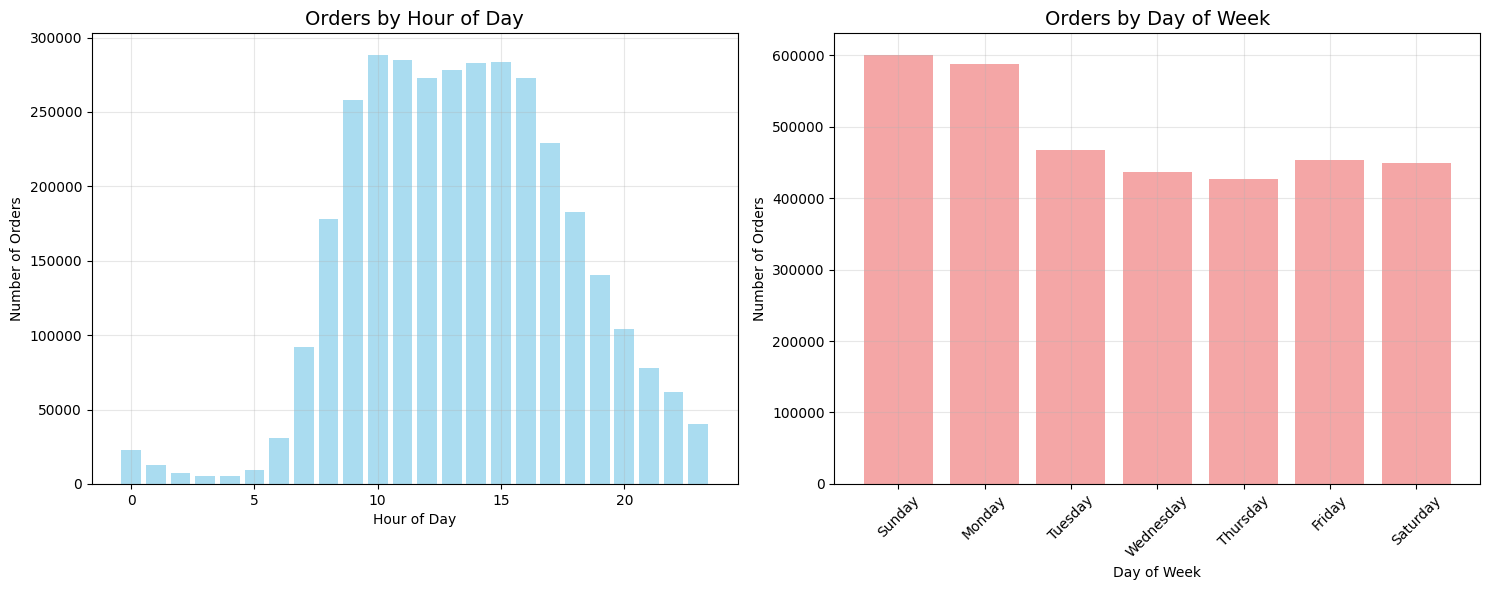

Key Insights:
- Peak ordering hour: 10:00 (288,418 orders)
- Most popular day: Sunday (600,905 orders)


In [7]:
# Temporal patterns analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Orders by hour of day
hour_dist = orders['order_hour_of_day'].value_counts().sort_index()
ax1.bar(hour_dist.index, hour_dist.values, color='skyblue', alpha=0.7)
ax1.set_title('Orders by Hour of Day', fontsize=14)
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Number of Orders')
ax1.grid(True, alpha=0.3)

# Orders by day of week
dow_dist = orders['order_dow'].value_counts().sort_index()
dow_labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
ax2.bar(dow_dist.index, dow_dist.values, color='lightcoral', alpha=0.7)
ax2.set_title('Orders by Day of Week', fontsize=14)
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('Number of Orders')
ax2.set_xticks(range(7))
ax2.set_xticklabels(dow_labels, rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key Insights:")
print(f"- Peak ordering hour: {hour_dist.idxmax()}:00 ({hour_dist.max():,} orders)")
print(f"- Most popular day: {dow_labels[dow_dist.idxmax()]} ({dow_dist.max():,} orders)")

### 3.2 Order Size and Reorder Analysis

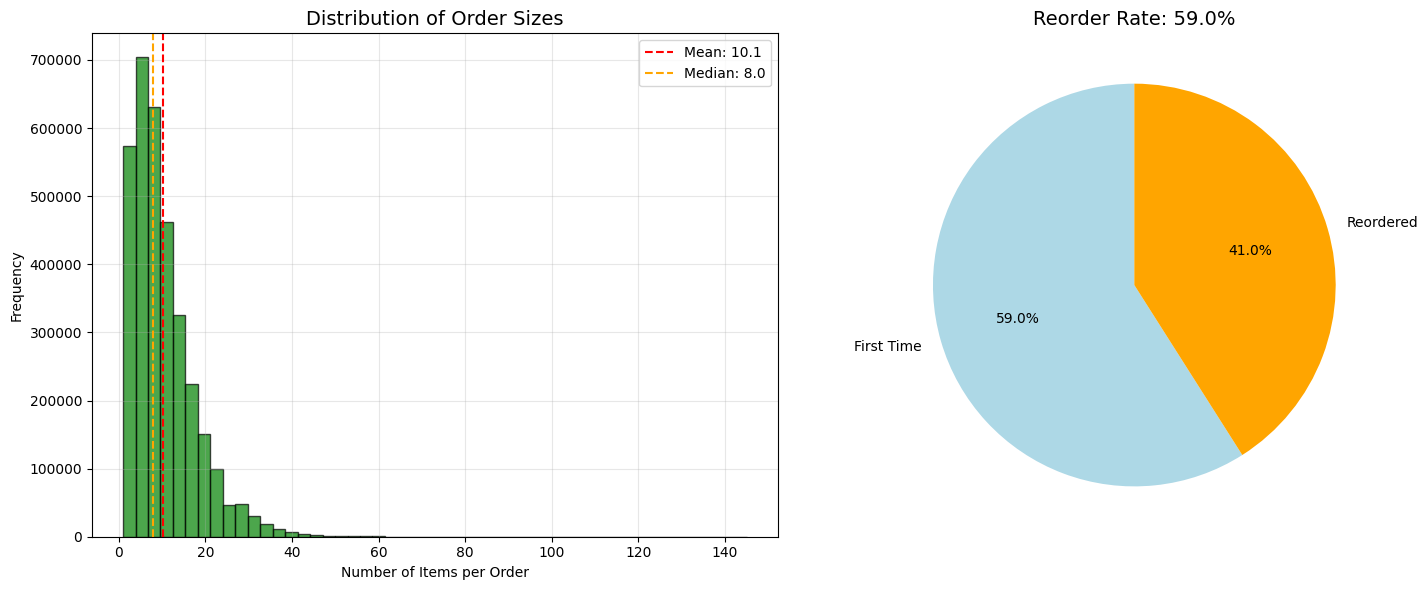

Order Size Statistics:
- Mean order size: 10.11
- Median order size: 8.00
- Max order size: 145

Reorder Statistics:
- Overall reorder rate: 59.0%
- Total reordered items: 19,955,360
- Total first-time items: 13,863,746


In [8]:
# Order size analysis
order_sizes = order_products.groupby('order_id').size()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Order size distribution
ax1.hist(order_sizes, bins=50, alpha=0.7, color='green', edgecolor='black')
ax1.set_title('Distribution of Order Sizes', fontsize=14)
ax1.set_xlabel('Number of Items per Order')
ax1.set_ylabel('Frequency')
ax1.axvline(order_sizes.mean(), color='red', linestyle='--', label=f'Mean: {order_sizes.mean():.1f}')
ax1.axvline(order_sizes.median(), color='orange', linestyle='--', label=f'Median: {order_sizes.median():.1f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Reorder rate analysis
reorder_rate = order_products['reordered'].mean()
reorder_counts = order_products['reordered'].value_counts()

ax2.pie(reorder_counts.values, labels=['First Time', 'Reordered'], autopct='%1.1f%%', 
        colors=['lightblue', 'orange'], startangle=90)
ax2.set_title(f'Reorder Rate: {reorder_rate:.1%}', fontsize=14)

plt.tight_layout()
plt.show()

print("Order Size Statistics:")
print(f"- Mean order size: {order_sizes.mean():.2f}")
print(f"- Median order size: {order_sizes.median():.2f}")
print(f"- Max order size: {order_sizes.max()}")
print(f"\nReorder Statistics:")
print(f"- Overall reorder rate: {reorder_rate:.1%}")
print(f"- Total reordered items: {reorder_counts[1]:,}")
print(f"- Total first-time items: {reorder_counts[0]:,}")

### 3.3 Product Popularity Analysis

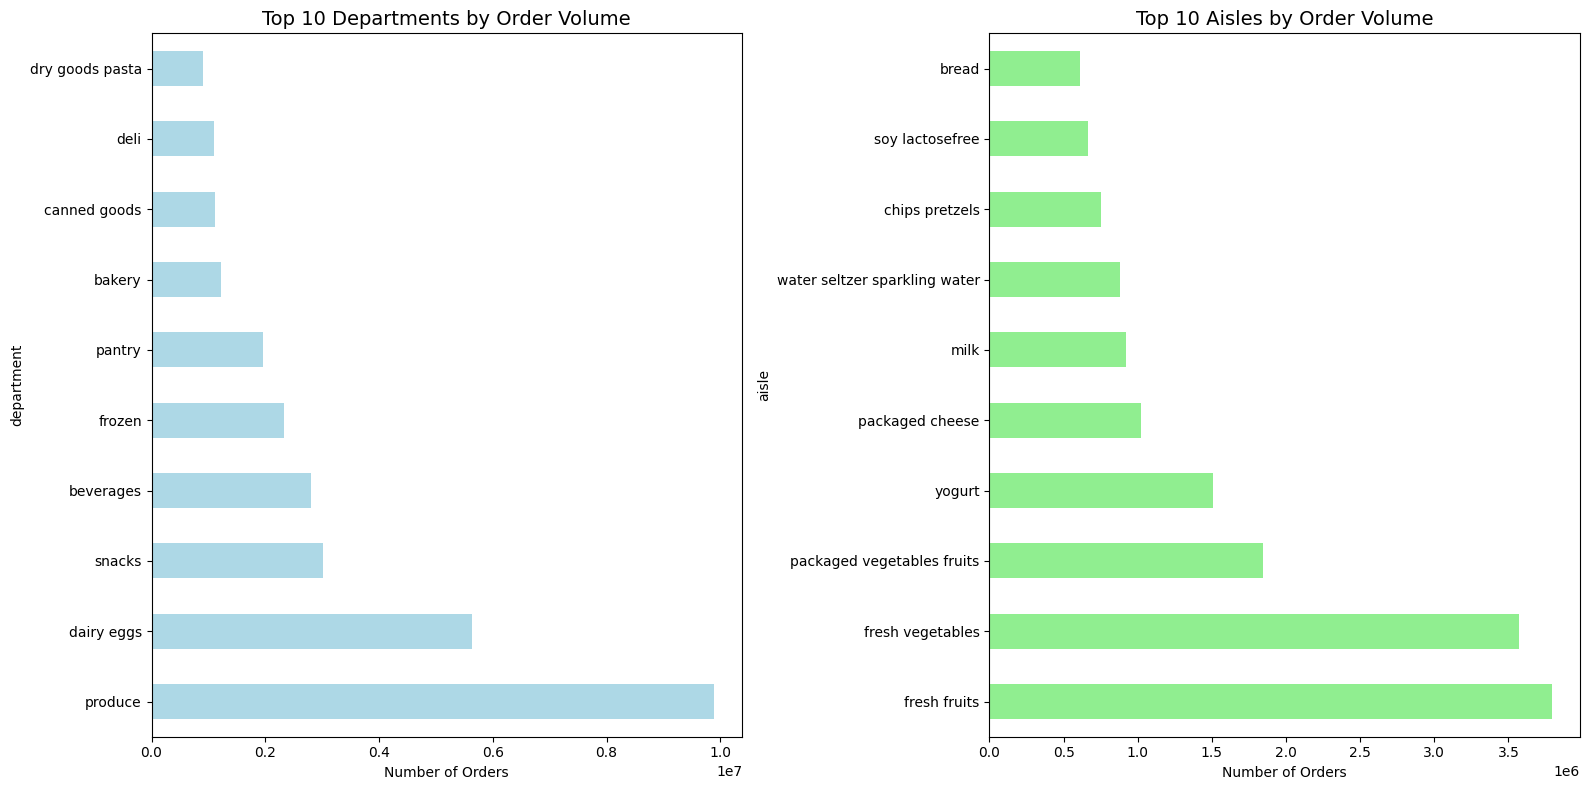

Top 5 Departments:
  produce: 9,888,378 orders
  dairy eggs: 5,631,067 orders
  snacks: 3,006,412 orders
  beverages: 2,804,175 orders
  frozen: 2,336,858 orders

Top 5 Aisles:
  fresh fruits: 3,792,661 orders
  fresh vegetables: 3,568,630 orders
  packaged vegetables fruits: 1,843,806 orders
  yogurt: 1,507,583 orders
  packaged cheese: 1,021,462 orders


In [9]:
# Department popularity analysis
dept_sales = order_products.merge(products_enriched, on='product_id') \
                           .groupby('department')['order_id'].count() \
                           .sort_values(ascending=False)

# Aisle popularity analysis
aisle_sales = order_products.merge(products_enriched, on='product_id') \
                            .groupby('aisle')['order_id'].count() \
                            .sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Top departments
dept_sales.head(10).plot(kind='barh', ax=ax1, color='lightblue')
ax1.set_title('Top 10 Departments by Order Volume', fontsize=14)
ax1.set_xlabel('Number of Orders')

# Top aisles
aisle_sales.head(10).plot(kind='barh', ax=ax2, color='lightgreen')
ax2.set_title('Top 10 Aisles by Order Volume', fontsize=14)
ax2.set_xlabel('Number of Orders')

plt.tight_layout()
plt.show()

print("Top 5 Departments:")
for dept, count in dept_sales.head().items():
    print(f"  {dept}: {count:,} orders")

print(f"\nTop 5 Aisles:")
for aisle, count in aisle_sales.head().items():
    print(f"  {aisle}: {count:,} orders")

## 4. RFM Analysis - Customer Segmentation

RFM Analysis segments customers based on:
- **Recency**: How recently did the customer make a purchase?
- **Frequency**: How often do they make purchases?
- **Monetary**: How much do they spend? (proxy: total products ordered)

Since Instacart doesn't have price data, we'll use total number of products as Monetary proxy.

In [10]:
# Calculate RFM metrics for each user
print("Calculating RFM metrics...")

# Step 1: Calculate user-level metrics
user_metrics = orders.groupby('user_id').agg({
    'order_number': 'max',  # Frequency: total number of orders
    'days_since_prior_order': ['max', 'mean']  # For recency calculations
}).round(2)

# Flatten column names
user_metrics.columns = ['frequency', 'recency_max', 'recency_avg']

# Step 2: Calculate monetary proxy (total products ordered per user)
user_products = order_products.groupby('order_id')['product_id'].count().reset_index()
user_products.columns = ['order_id', 'products_count']

# Join with orders to get user_id
order_user_products = orders[['order_id', 'user_id']].merge(user_products, on='order_id')
monetary_proxy = order_user_products.groupby('user_id')['products_count'].sum().reset_index()
monetary_proxy.columns = ['user_id', 'monetary']

# Step 3: Combine all metrics
rfm_data = user_metrics.merge(monetary_proxy, on='user_id', how='left')

# Handle recency (use the average days between orders as primary recency metric)
# For users with only 1 order, use a default high value (indicating low recency)
rfm_data['recency'] = rfm_data['recency_avg'].fillna(365)  # 365 days for single-order users

print(f"RFM data shape: {rfm_data.shape}")
print("\nRFM data sample:")
display(rfm_data.head(10))

Calculating RFM metrics...
RFM data shape: (206209, 6)

RFM data sample:


,user_id,frequency,recency_max,recency_avg,monetary,recency
0,1,11,30.0,19.00,70,19.00
1,2,15,30.0,16.29,226,16.29
2,3,13,21.0,12.00,88,12.00
3,4,6,30.0,17.00,18,17.00
4,5,5,19.0,11.50,46,11.50
5,6,4,22.0,13.33,14,13.33
6,7,21,30.0,10.45,215,10.45
7,8,4,30.0,23.33,67,23.33
8,9,4,30.0,22.00,98,22.00
9,10,6,30.0,21.80,147,21.80


In [11]:
# RFM Scoring using quintiles (1-5 scale)
print("Creating RFM scores...")

# Calculate quintiles for each metric
rfm_data['R_score'] = pd.qcut(rfm_data['recency'].rank(method='first'), 5, labels=[5,4,3,2,1])  # Lower recency = better (5)
rfm_data['F_score'] = pd.qcut(rfm_data['frequency'], 5, labels=[1,2,3,4,5])  # Higher frequency = better (5)
rfm_data['M_score'] = pd.qcut(rfm_data['monetary'], 5, labels=[1,2,3,4,5])  # Higher monetary = better (5)

# Convert to numeric for easier manipulation
rfm_data['R_score'] = rfm_data['R_score'].astype(int)
rfm_data['F_score'] = rfm_data['F_score'].astype(int)
rfm_data['M_score'] = rfm_data['M_score'].astype(int)

# Create RFM composite score
rfm_data['RFM_score'] = rfm_data['R_score'].astype(str) + rfm_data['F_score'].astype(str) + rfm_data['M_score'].astype(str)

print("RFM scores distribution:")
print(f"R_score: {rfm_data['R_score'].value_counts().sort_index()}")
print(f"\nF_score: {rfm_data['F_score'].value_counts().sort_index()}")
print(f"\nM_score: {rfm_data['M_score'].value_counts().sort_index()}")

display(rfm_data[['user_id', 'recency', 'frequency', 'monetary', 'R_score', 'F_score', 'M_score', 'RFM_score']].head(10))

Creating RFM scores...
RFM scores distribution:
R_score: R_score
1    41242
2    41242
3    41241
4    41242
5    41242
Name: count, dtype: int64

F_score: F_score
1    43576
2    41715
3    40225
4    40482
5    40211
Name: count, dtype: int64

M_score: M_score
1    41697
2    41801
3    40316
4    41229
5    41166
Name: count, dtype: int64


,user_id,recency,frequency,monetary,R_score,F_score,M_score,RFM_score
0,1,19.00,11,70,2,3,3,233
1,2,16.29,15,226,3,4,4,344
2,3,12.00,13,88,4,3,3,433
3,4,17.00,6,18,3,2,1,321
4,5,11.50,5,46,4,1,2,412
5,6,13.33,4,14,3,1,1,311
6,7,10.45,21,215,4,4,4,444
7,8,23.33,4,67,1,1,2,112
8,9,22.00,4,98,2,1,3,213
9,10,21.80,6,147,2,2,4,224


In [12]:
# Define customer segments based on RFM scores
def segment_customers(row):
    """
    Segment customers based on RFM scores
    """
    r, f, m = row['R_score'], row['F_score'], row['M_score']
    
    # Champions (best customers)
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    # Loyal Customers
    elif r >= 3 and f >= 4 and m >= 3:
        return 'Loyal Customers'
    # Potential Loyalists
    elif r >= 4 and f >= 2 and m >= 2:
        return 'Potential Loyalists'
    # New Customers
    elif r >= 4 and f == 1:
        return 'New Customers'
    # Promising
    elif r >= 3 and f >= 2 and m >= 2:
        return 'Promising'
    # Need Attention
    elif r >= 3 and f >= 2 and m <= 2:
        return 'Need Attention'
    # About to Sleep
    elif r >= 2 and f >= 2:
        return 'About to Sleep'
    # At Risk
    elif r <= 2 and f >= 3:
        return 'At Risk'
    # Cannot Lose Them
    elif r <= 2 and f >= 4 and m >= 4:
        return 'Cannot Lose'
    # Hibernating
    elif r <= 2 and f <= 2 and m >= 3:
        return 'Hibernating'
    # Lost
    else:
        return 'Lost'

# Apply segmentation
rfm_data['Segment'] = rfm_data.apply(segment_customers, axis=1)

# Display segment distribution
segment_counts = rfm_data['Segment'].value_counts()
print("Customer Segments Distribution:")
print(segment_counts)
print(f"\nTotal customers: {segment_counts.sum():,}")

Customer Segments Distribution:
Segment
Champions              47277
Lost                   41281
About to Sleep         32178
Loyal Customers        21351
Potential Loyalists    18168
Promising              15105
Hibernating             8279
New Customers           8278
At Risk                 7389
Need Attention          6903
Name: count, dtype: int64

Total customers: 206,209


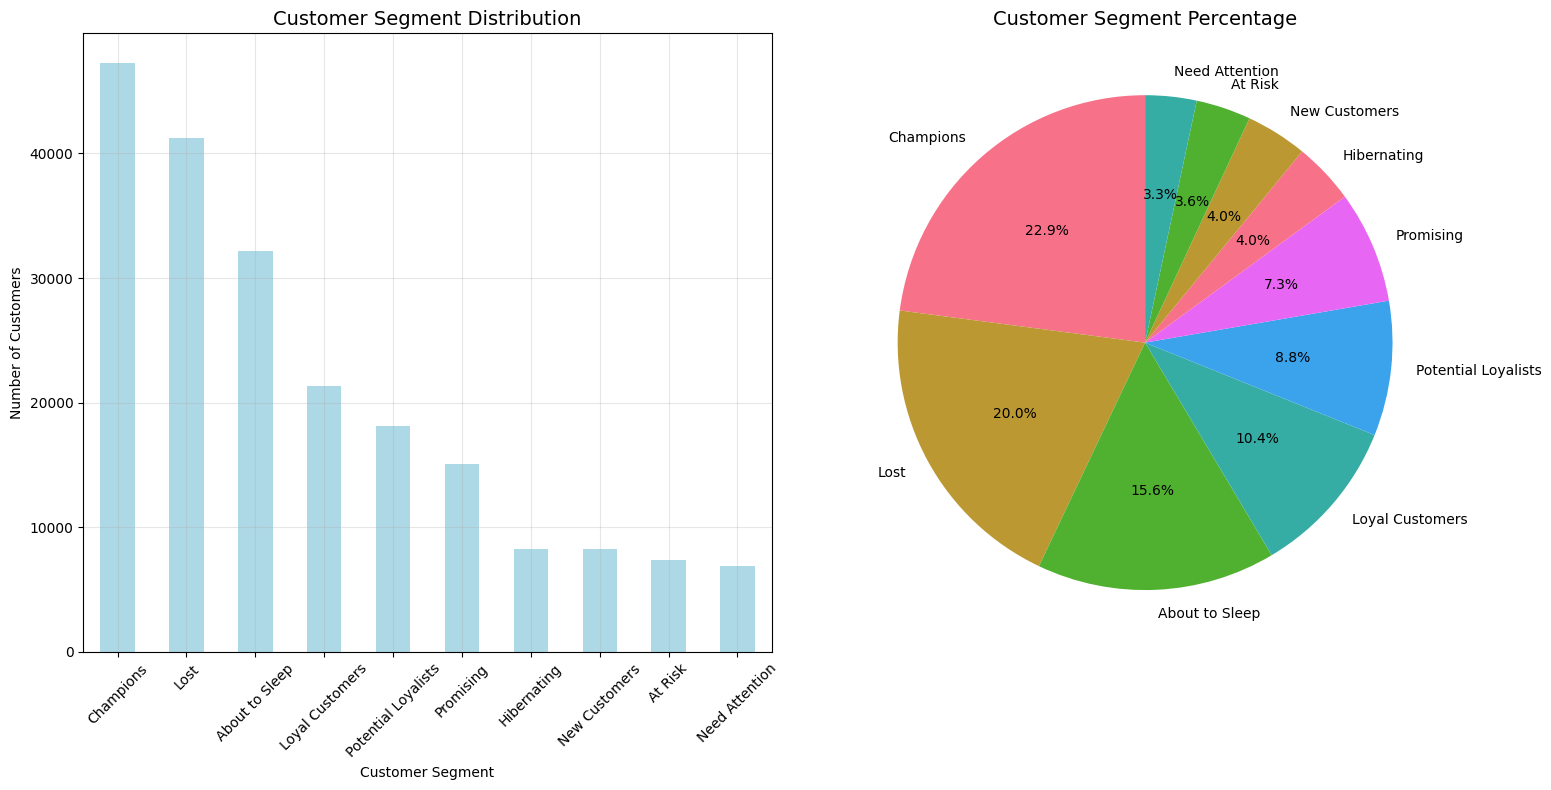


Segment Percentage Breakdown:
  Champions: 22.9% (47,277 customers)
  Lost: 20.0% (41,281 customers)
  About to Sleep: 15.6% (32,178 customers)
  Loyal Customers: 10.4% (21,351 customers)
  Potential Loyalists: 8.8% (18,168 customers)
  Promising: 7.3% (15,105 customers)
  Hibernating: 4.0% (8,279 customers)
  New Customers: 4.0% (8,278 customers)
  At Risk: 3.6% (7,389 customers)
  Need Attention: 3.3% (6,903 customers)


In [13]:
# Visualize RFM segments
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Segment distribution bar chart
segment_counts.plot(kind='bar', ax=ax1, color='lightblue', rot=45)
ax1.set_title('Customer Segment Distribution', fontsize=14)
ax1.set_xlabel('Customer Segment')
ax1.set_ylabel('Number of Customers')
ax1.grid(True, alpha=0.3)

# Segment distribution pie chart
segment_counts.plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90)
ax2.set_title('Customer Segment Percentage', fontsize=14)
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

# Show percentage breakdown
segment_pct = (segment_counts / segment_counts.sum() * 100).round(1)
print("\nSegment Percentage Breakdown:")
for segment, pct in segment_pct.items():
    print(f"  {segment}: {pct}% ({segment_counts[segment]:,} customers)")

## 5. Save Processed Data

In [14]:
# Save processed datasets for downstream analysis
print("Saving processed datasets...")

# 1. Save RFM data 
rfm_output = rfm_data[['user_id', 'recency', 'frequency', 'monetary', 'R_score', 'F_score', 'M_score', 'RFM_score', 'Segment']]
rfm_output.to_parquet(DATA_PROCESSED_PATH + "users_rfm.parquet", index=False)
print(f"✓ Saved RFM data: {rfm_output.shape}")

# 2. Save enriched products dataset
products_enriched.to_parquet(DATA_PROCESSED_PATH + "products_enriched.parquet", index=False)
print(f"✓ Saved enriched products: {products_enriched.shape}")

# 3. Save combined order products (if needed for further analysis)
# order_products.to_parquet(DATA_PROCESSED_PATH + "order_products_combined.parquet", index=False)
# print(f"✓ Saved combined order products: {order_products.shape}")

print(f"\nProcessed files saved to: {DATA_PROCESSED_PATH}")
print("Files ready for dashboard creation and model training.")

Saving processed datasets...
✓ Saved RFM data: (206209, 9)
✓ Saved enriched products: (49688, 6)

Processed files saved to: ../data/processed/
Files ready for dashboard creation and model training.


## 6. Key Insights & Business Recommendations

### Key Findings from EDA & RFM Analysis:

#### Temporal Patterns:
- **Peak ordering time**: 10:00 AM (288K orders) - morning grocery shopping
- **Most popular day**: Sunday (600K orders) - weekend preparation
- **Shopping patterns**: Clear preference for morning hours (9-15) and weekends

#### Order Behavior:
- **Average order size**: 10.1 items (median: 8 items)
- **Reorder rate**: 59% - high customer loyalty to specific products
- **Total dataset**: 206K users, 3.4M orders, 33.8M order items

#### Product Preferences:
- **Top category**: Produce (fresh fruits & vegetables) dominates
- **Fresh fruits**: 3.8M orders, Fresh vegetables: 3.6M orders
- **Consumer preference**: Healthy, fresh products are most popular

#### RFM Customer Segmentation:
- **Champions (22.9%)**: Best customers - high value, frequent, recent
- **Lost (20.0%)**: Need reactivation campaigns
- **About to Sleep (15.6%)**: Risk of churn - need attention
- **Loyal Customers (10.4%)**: Stable revenue base
- **Total of 70%+ customers** are either Champions, Lost, or sleeping - high potential value

### Business Recommendations:

#### For Champions (47K customers, 22.9%):
- **VIP programs** with exclusive benefits
- **Early access** to new products
- **Loyalty rewards** to maintain engagement

#### For Lost Customers (41K customers, 20.0%):
- **Win-back campaigns** with discounts
- **Product recommendations** based on past purchases  
- **Survey campaigns** to understand reasons for leaving

#### For About to Sleep (32K customers, 15.6%):
- **Proactive engagement** before they become lost
- **Personalized offers** on frequently purchased items
- **Reminder campaigns** for reorders

#### Operational Insights:
- **Inventory management**: Focus on fresh produce, especially mornings/weekends
- **Marketing timing**: Target campaigns for Sunday/morning shopping
- **Product strategy**: Leverage 59% reorder rate for subscription services